1. Выберите ряд из первого задания.   
2. Постройте его модель ARIMA.   
3. Оформите отчёт в Jupyter-ноутбук.

*Дополнительное задание   
Попробуйте спрогнозировать график классическим ML.   

In [64]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [7]:
%matplotlib inline

In [80]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
df = pd.read_csv('monthly-sales-of-company-x-jan-6.csv', sep=',')
df.head(2)

,Month,Count
0,1965-01,154
1,1965-02,96


In [21]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [23]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


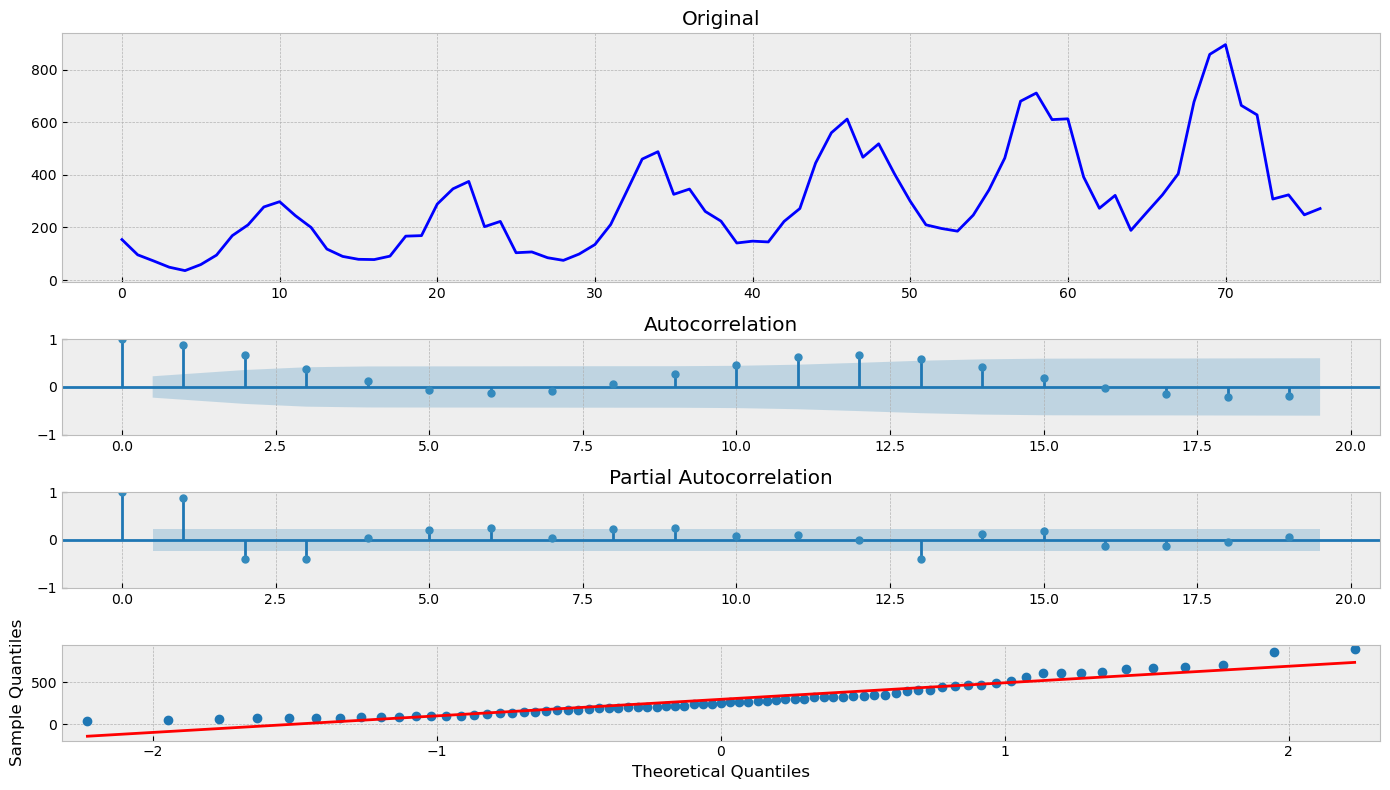

In [27]:
tsplot(df.Count)

In [126]:
series = df.Count
series = boxcox(series, 0) #cтабилизируем дисперсию
series = series[12:] - series[:-12] #убираем сезонность
series = series[1:] - series[:-1] #убираем сезонность
series = series[7:] - series[:-7] #убираем сезонность
series = pd.Series(series)

Results of Dickey-Fuller Test:
Test Statistic                 -4.590566
p-value                         0.000134
#Lags Used                      7.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64


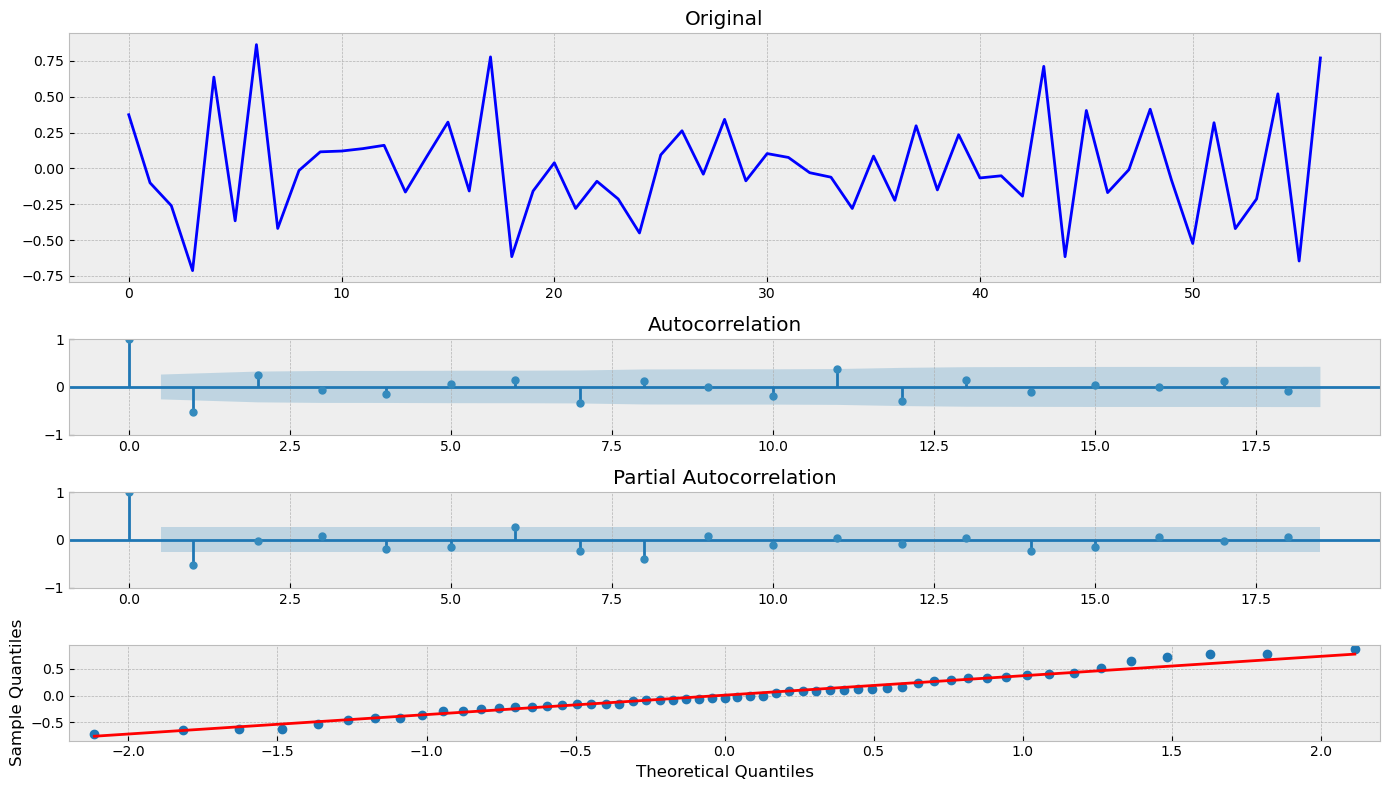

In [128]:
tsplot(series)

In [204]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [216]:
best_aic = np.inf 
best_order = None
best_mdl = None
series = df.Count

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = ARIMA(series, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 854.02138 | order: (4, 2, 3)


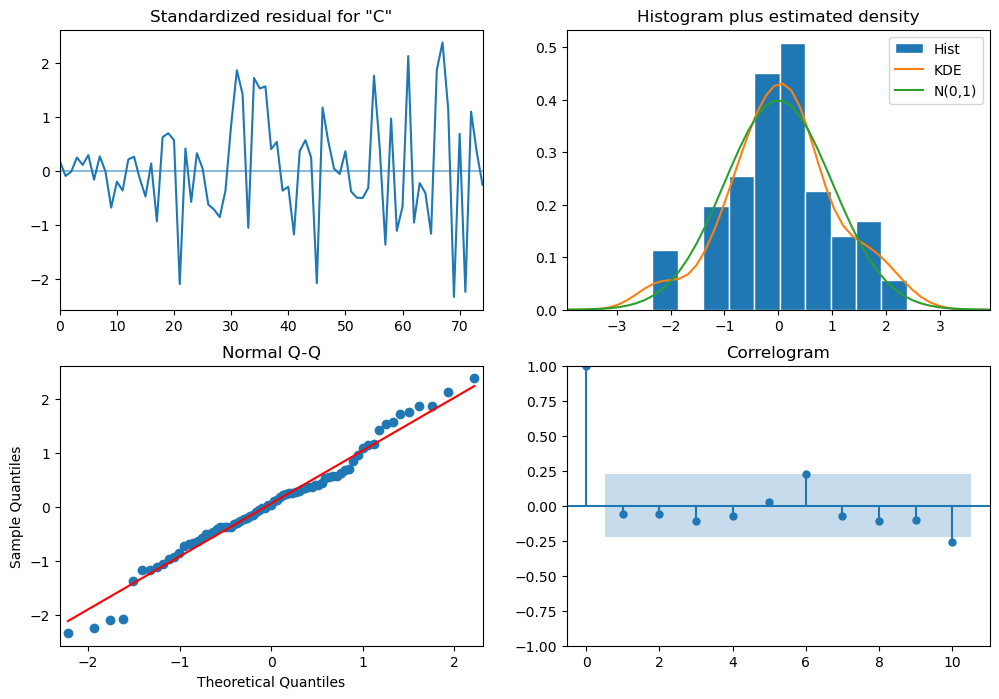

In [217]:
best_mdl.plot_diagnostics(figsize=(12, 8))
plt.show()

In [238]:
st_pred = best_mdl.get_prediction() 
forecast_values = st_pred.predicted_mean

In [240]:
actual_values = df.Count
forecast_mse = ((forecast_values - actual_values) ** 2).mean()
print('Среднеквадратичная ошибка прогноза составляет {}'.format(round(forecast_mse, 2)))

Среднеквадратичная ошибка прогноза составляет 3791.65


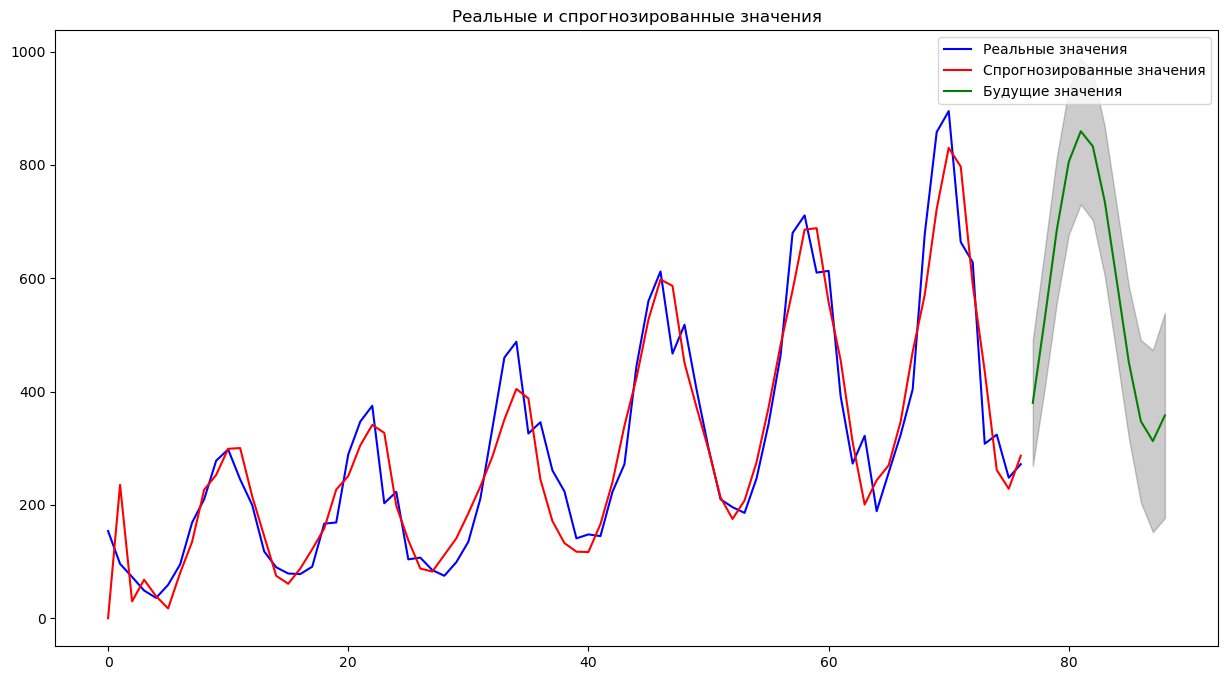

In [270]:
plt.figure(figsize=(15,8))
plt.plot(actual_values.index, actual_values, label='Реальные значения', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Спрогнозированные значения', color='red')
plt.title('Реальные и cпрогнозированные значения')

pred_future = best_mdl.get_forecast(steps=12)
plt.plot(pred_future.predicted_mean, label='Будущие значения', color='green')

plt.fill_between(pred_future.conf_int().index,
                 pred_future.conf_int().iloc[:, 0],
                 pred_future.conf_int().iloc[:, 1], color='k', alpha=.2)
plt.legend()  
plt.show()